# CS 6320 Project 2: Detecting Lines and Circles using Hough Transform

A notebook contains many blocks of code, each of which can be run independently. You can run a cell with ctrl+enter or shift+enter (to move to the next cell).


You are expected to complete this notebook with lines of code, plots and texts. You will need to create new cells with original code or text for your analyses and explanations. Explain what you do and analyze your results. This assignment has a total of 100 points.

## Brief
    Hand-in: through Gradescope
    Required files: <your_uid>.zip.(Please begin with 'u' for your uid)
<!---<your_uid>_proj1.pdf--> 


## Setup

   0. Unzip proj2_6320.zip and go to proj2_6320 directory.
      - You can run `unzip proj2_6320.zip && cd proj2_6320` in your terminal.
   1. Install [Miniconda](https://docs.conda.io/en/latest/miniconda.html). It doesn’t matter whether you use Python 2 or 3 because we will create our own environment that uses 3 anyways.
   2. Create a conda environment using the appropriate command. On Windows, open the installed “Conda prompt” to run the command. On MacOS and Linux, you can just use a terminal window to run the command, Modify the command based on your OS (linux, mac, or win): `conda env create -f proj2_env.yml`.
    - NOTE that proj2_env.yml is inside the project folder.
   3. This should create an environment named ‘proj2’. Activate it using the Windows command, activate proj2 or the MacOS / Linux command, source activate proj2
   4. Run the notebook using `jupyter notebook` under *proj2_6320* directory.
   5. Ensure that all sanity checks are passing by running pytest tests inside the repo folder.
   6. Generate the zip folder for the code portion of your submission once you’ve finished the project using 
    
        `python zip_submission.py --uid <your_uid>` 


## Library Functions
Do not use any library functions that implement Hough Transform in your solution. You can use functions to perform fitlering etc.

## Debugging
We have included several synthetic images of lines and circles to help test your methods in simpler domains if you'd like.

## Writeup
For this project, this notebook itself is the report. You must run all your cells before you hand it in. Your code, results, visualization, and discussion will be used for the grading. You will be deducted points if the results are not shown in this notebook. Do not change the order of the cells. You can add cells in need. You can copy a cell and run it seperately if you need to run a cell multiple times and thus every result is displayed in the cell.


## Rubric
    +34 pts: Ques_1
    +20 pts: Ques_2
    +22 pts: Ques_3
    +24 pts: Ques_4
    +10 pts: Ques_5 (extra credits)
    

    Distribution of the points in a Question is separately mentioned for each sub-task

    -5*n pts: Lose 5 points for every time you do not follow the instructions for the hand-in format.
    
Submission Format

This is very important as you will lose 5 points for every time you do not follow the instructions. You will attach two items in your submission on Canvas:

1. <your_uid>.zip containing:
    - proj2_code/ - directory containing all your code for this assignment
    - data/       - directory containing all the input images
    - results/    - directory containing all your output images

Do not install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config files we provide you, so anything that’s not in there by default will probably cause your code to break during grading. Do not use absolute paths in your code or your code will break. Use relative paths like the starter code already does. Failure to follow any of these instructions will lead to point deductions. Create the zip file using python zip_submission.py --uid <your_uid> (it will zip up the appropriate directories/files for you!)

**Note:**: Make sure all the images saved in the results directory are plotted in your Jupyter notebook.

In [1]:
import numpy as np
import cv2 as cv
import matplotlib
import matplotlib.pyplot as plt
import math

### 1 Processing an image to detect lines using Hough Transform (34 points)

In this question, we process an image and apply Hough Transform on the processed image

#### Tasks:
1. Compute a smooth version of the Input Image <b>(5 points)</b>
2. Detect edges from Images <b>(8 points)</b>
3. Implement Hough Transform <b>(10 points)</b>
4. Apply Hough Transform to detect lines from images <b>(4 points)</b>
5. Apply Hough Transform to detect edges from images <b>(7 points)</b>

#### 1.1 Compute a smooth version of the Input Image

##### You should use a Gaussian filter to generate a smooth image 

##### Please note:
The function takes in as input only the sigma value (integer only).<br>
The size of the filter should be computed using the sigma value

In [2]:
def Gaussian_Filter(sigma):
    '''
    The function takes as input only the sigma (integer)
    and generates a Gaussian filter using this sigma value.
    The size of the filter should be computed using the sigma value.
    '''

    ############################
    ### TODO: Your Implementation
    # sigma is the std dev of gaussian distribution. Controls spread of curve
    size = 2 * int(3 * sigma) + 1
    # coordinate grid
    x = np.arange(-int(size/2), int(size/2) + 1)
    y = np.arange(-int(size/2), int(size/2) + 1)
    x, y = np.meshgrid(x, y)
    # actual gaussian filter
    g_filter = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    # Normalize the filter
    g_filter /= np.sum(g_filter)
    return g_filter
    ### END OF STUDENT CODE ####
    ############################

(-0.5, 699.5, 524.5, -0.5)

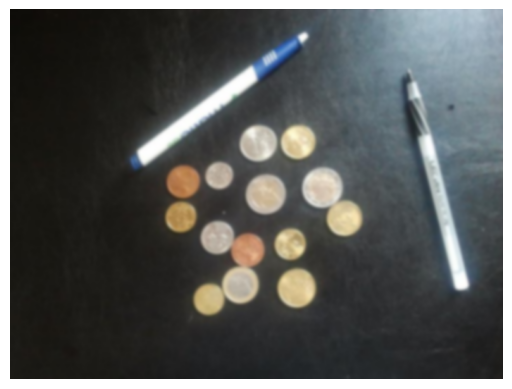

In [3]:
# Reading the Input Image
img = cv.imread('../data/proj2-clean-image.jpg')

# Generates the Gaussian Filter
g_kernel = Gaussian_Filter(2)

# Smoothing the image with the Gaussian Filter
smooth_img = cv.filter2D(img, -1, g_kernel)

# Saves the smoothed image in the result directory
cv.imwrite("../results/Ques_1/proj2-clean-image-smoothed.png", smooth_img)

# Plots the smoothed image in the notebook (convert BGR to RGB for correct colors)
plt.figure()
plt.imshow(cv.cvtColor(smooth_img, cv.COLOR_BGR2RGB))
plt.axis('off')

In [4]:
def rgb2gray(rgb):
    '''
    Converts an RGB image to Grayscale.
    
    Args:
        rgb : np.ndarray
            Input image of shape (H, W, 3) in RGB format.
    
    Returns:
        gray : np.ndarray
            Grayscale image of shape (H, W).
    '''
    # NOTE: Input must be in RGB format (convert with cv.cvtColor if using cv.imread).
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

In [5]:
def image_uint(input_arr):
    '''
    Scales the image intensity values to the range [0, 255].

    Args:
        input_arr : np.ndarray
            Input image (any numeric dtype).

    Returns:
        np.ndarray
            Image scaled to uint8 with values in [0, 255].
    '''
    min_val, max_val = np.min(input_arr), np.max(input_arr)
    if max_val == min_val:
        return np.zeros_like(input_arr, dtype=np.uint8)
    scaled = 255.0 * (input_arr - min_val) / (max_val - min_val)
    return scaled.astype(np.uint8)

#### 1.2 Edge Detector
Now we need to extract the edges from the input images. This is as essential step towards detection of lines and circles from the image.

#### You should define a Sobel filter to detect edges in the Original and Smooth Image
Following the definition of the filter, you convolve the filter over the input image using OpenCV library function, <b>filter2D()</b>. You are not required to write any convolution function to apply the filter.

You are required to detect edges on both the <b>original</b> and <b>smooth</b> images.

<b>Do you observe any difference between them? Please comment in a separate cell.</b>

#### 1.2.1 Edge Detector on the Original Image
Please remember the edge detection method should be applied on <b>gray images</b>.
The edge image should be saved as <b>img_gray_edge</b>.

(-0.5, 699.5, 524.5, -0.5)

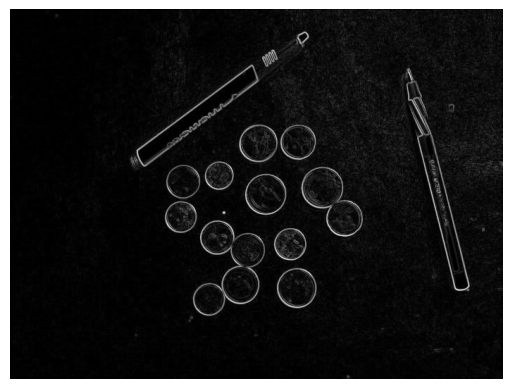

In [6]:
def detect_edges_with_sobel(image):
    '''
    Detects edges in a grayscale image using Sobel filters.

    Input:
        image : np.ndarray
            Grayscale image on which edges are to be detected.

    Output:
        img_gray_edge : np.ndarray
            Image with detected edges.

    Description:
        1. Convolve the input image with the Sobel_x filter and Sobel_y filter separately.
        2. Compute the gradient magnitude from the x and y gradients.
    '''
    ############################
    ### TODO: Your Implementation ###
    # Define Sobel kernels
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)

    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]], dtype=np.float32)

    # Convolve with Sobel filters
    grad_x = cv.filter2D(image, cv.CV_64F, sobel_x)
    grad_y = cv.filter2D(image, cv.CV_64F, sobel_y)

    # Compute gradient magnitude
    img_gray_edge = np.sqrt(grad_x**2 + grad_y**2)

    # normalize from 0–255
    img_gray_edge = (img_gray_edge / img_gray_edge.max()) * 255
    img_gray_edge = img_gray_edge.astype(np.uint8)
    
    ############################
    ### Your Implementation ENDS here ###
    ############################

    return img_gray_edge

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img_gray_edge = detect_edges_with_sobel(gray)
# Save the Image
cv.imwrite('../results/Ques_1/Ori_Clean_Edge_Image.png', img_gray_edge)

# Plot the Image
plt.figure()
plt.imshow(img_gray_edge.astype(np.uint8), cmap='gray')
plt.axis('off')

#### 1.2.2 Edge Detector on the Smooth Image
Please remember the edge detection method should be applied on <b>gray images</b>.
The edge image should be saved as <b>smooth_img_gray_edge</b>.

(-0.5, 699.5, 524.5, -0.5)

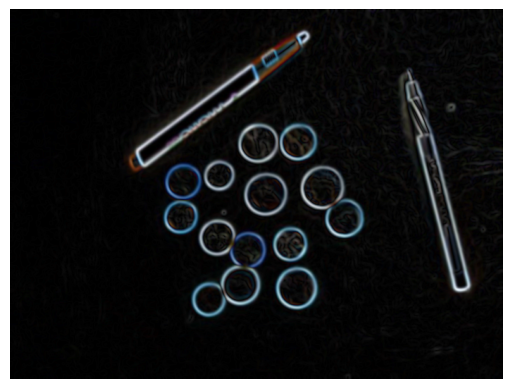

In [7]:
############################
### TODO: Your Implementation ###
smooth_gray = cv.cvtColor(smooth_img, cv.COLOR_BGR2GRAY)
smooth_img_gray_edge = detect_edges_with_sobel(smooth_img)
############################
### Your Implementation ENDS here ###
############################

# Save the Image
cv.imwrite('../results/Ques_1/Smooth_Clean_Edge_Image.png', smooth_img_gray_edge)

# Plot the Image
plt.figure()
plt.imshow(smooth_img_gray_edge.astype(np.uint8), cmap='gray')
plt.axis('off')

#### 1.3 Hough Transform to detect Lines
In this exercise you are expected to implement Hough Transform for line detection as discussed in class. Hough Transform uses an accumulator array to capture the lines present in image. It is applied on binary images which can be generated by thresholding the edge detector output.<br>

For this exercise, the range of theta is <b>[-90, 90]</b> and the range of rho is <b>[-img_diag, img_diag]</b>.<br>

For example:<br>
If theta_res = <b>1</b>, we consider the lines at angle <b>-90, -89, -88, ...., 89</b>.<br>
If rho_res = <b>1</b>, we consider the distances at <b>-img_diag, -img_diag + 1, ..., img_diag - 1</b>.

In [8]:
def hough_transform(input_img, threshold, theta_res, rho_res):
    '''
    This function computes the Hough Transform accumulator array for line detection.

    Input:
        input_img : np.ndarray
            Output of the Edge Detection method (grayscale).
        threshold : int or float
            Threshold value for generating the binary edge image.
        theta_res : int
            Resolution (step size) for angle θ, in degrees.
        rho_res : int
            Resolution (step size) for perpendicular distance ρ from the origin.

    Output:
        accumulator : np.ndarray
            The Hough accumulator array.
        thetas : np.ndarray
            Array of θ values used in the transform.
        rhos : np.ndarray
            Array of ρ values used in the transform.
        binary_img : np.ndarray
            Thresholded binary edge image.
    '''
    ############################
    ### TODO: Your Implementation ###
    
    #create a binary image
    _, binary_img = cv.threshold(input_img, threshold, 255, cv.THRESH_BINARY)
    
    # canny_low_threshold = 50  # Start here and adjust (e.g., 30 to 70)
    # canny_high_threshold = 150 # Start here and adjust (e.g., 100 to 200)
    
    # binary_img = cv.Canny(
    #     clutter_smooth_img_gray_edge, 
    #     canny_low_threshold, 
    #     canny_high_threshold
    # )
    # Get image dimensions
    height, width = binary_img.shape
    # Calculate the diagonal length
    img_diag = int(np.ceil(np.sqrt(height**2 + width**2)))
    # Theta and Rho ranges
    thetas = np.deg2rad(np.arange(-90, 90 + theta_res, theta_res))
    rhos = np.arange(-img_diag, img_diag + rho_res, rho_res)
    # accumulator array to count votes
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    # Find indices of edge pixels
    y_idxs, x_idxs = np.nonzero(binary_img)
    # Vote in the accumulator array
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx in range(len(thetas)):
            theta = thetas[t_idx]
            rho = x * np.cos(theta) + y * np.sin(theta)
            rho_idx = int(np.round((rho + img_diag) / rho_res))
            accumulator[rho_idx, t_idx] += 1
    ############################
    ### Your Implementation ENDS here ###
    ############################

    return accumulator, thetas, rhos, binary_img

#### 1.3.1 Hough Transform to detect Lines from Original Image

Use the edges detected from the <b>original input image</b> to apply Hough Transform function.<br>
<br>

You need to find a resaonable estimate of the threshold for generating the binary image which is good enough for the Hough transform to extract lines. Please discuss the effect of the threshold on the performance of the algorithm.

Plot the Accumulator Array using the matplotlib function, figure size (20, 20), with proper labeling and title. The image should be saved as <b>Ori_Clean_Image_Accumulator_Array.png</b> in results/Ques_1 sub-directory.

**Note:** If the aspect ratio of the Accumulator Array plot appears skewed, you can adjust it for better visualization by using `interpolation='none'` and `aspect='auto'` with `plt.imshow`. For example: `plt.imshow(image, interpolation='none', aspect='auto')`. This ensures the pixels are displayed without interpolation and the aspect ratio is automatically adjusted to fit the plot area.


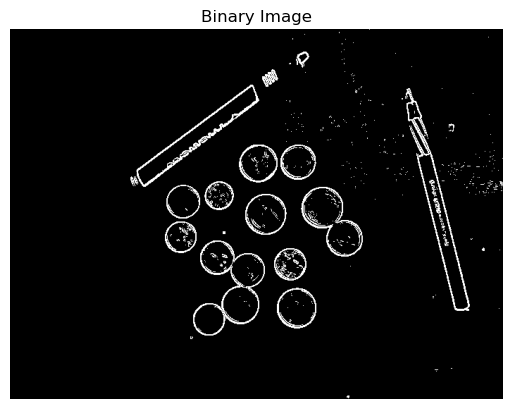

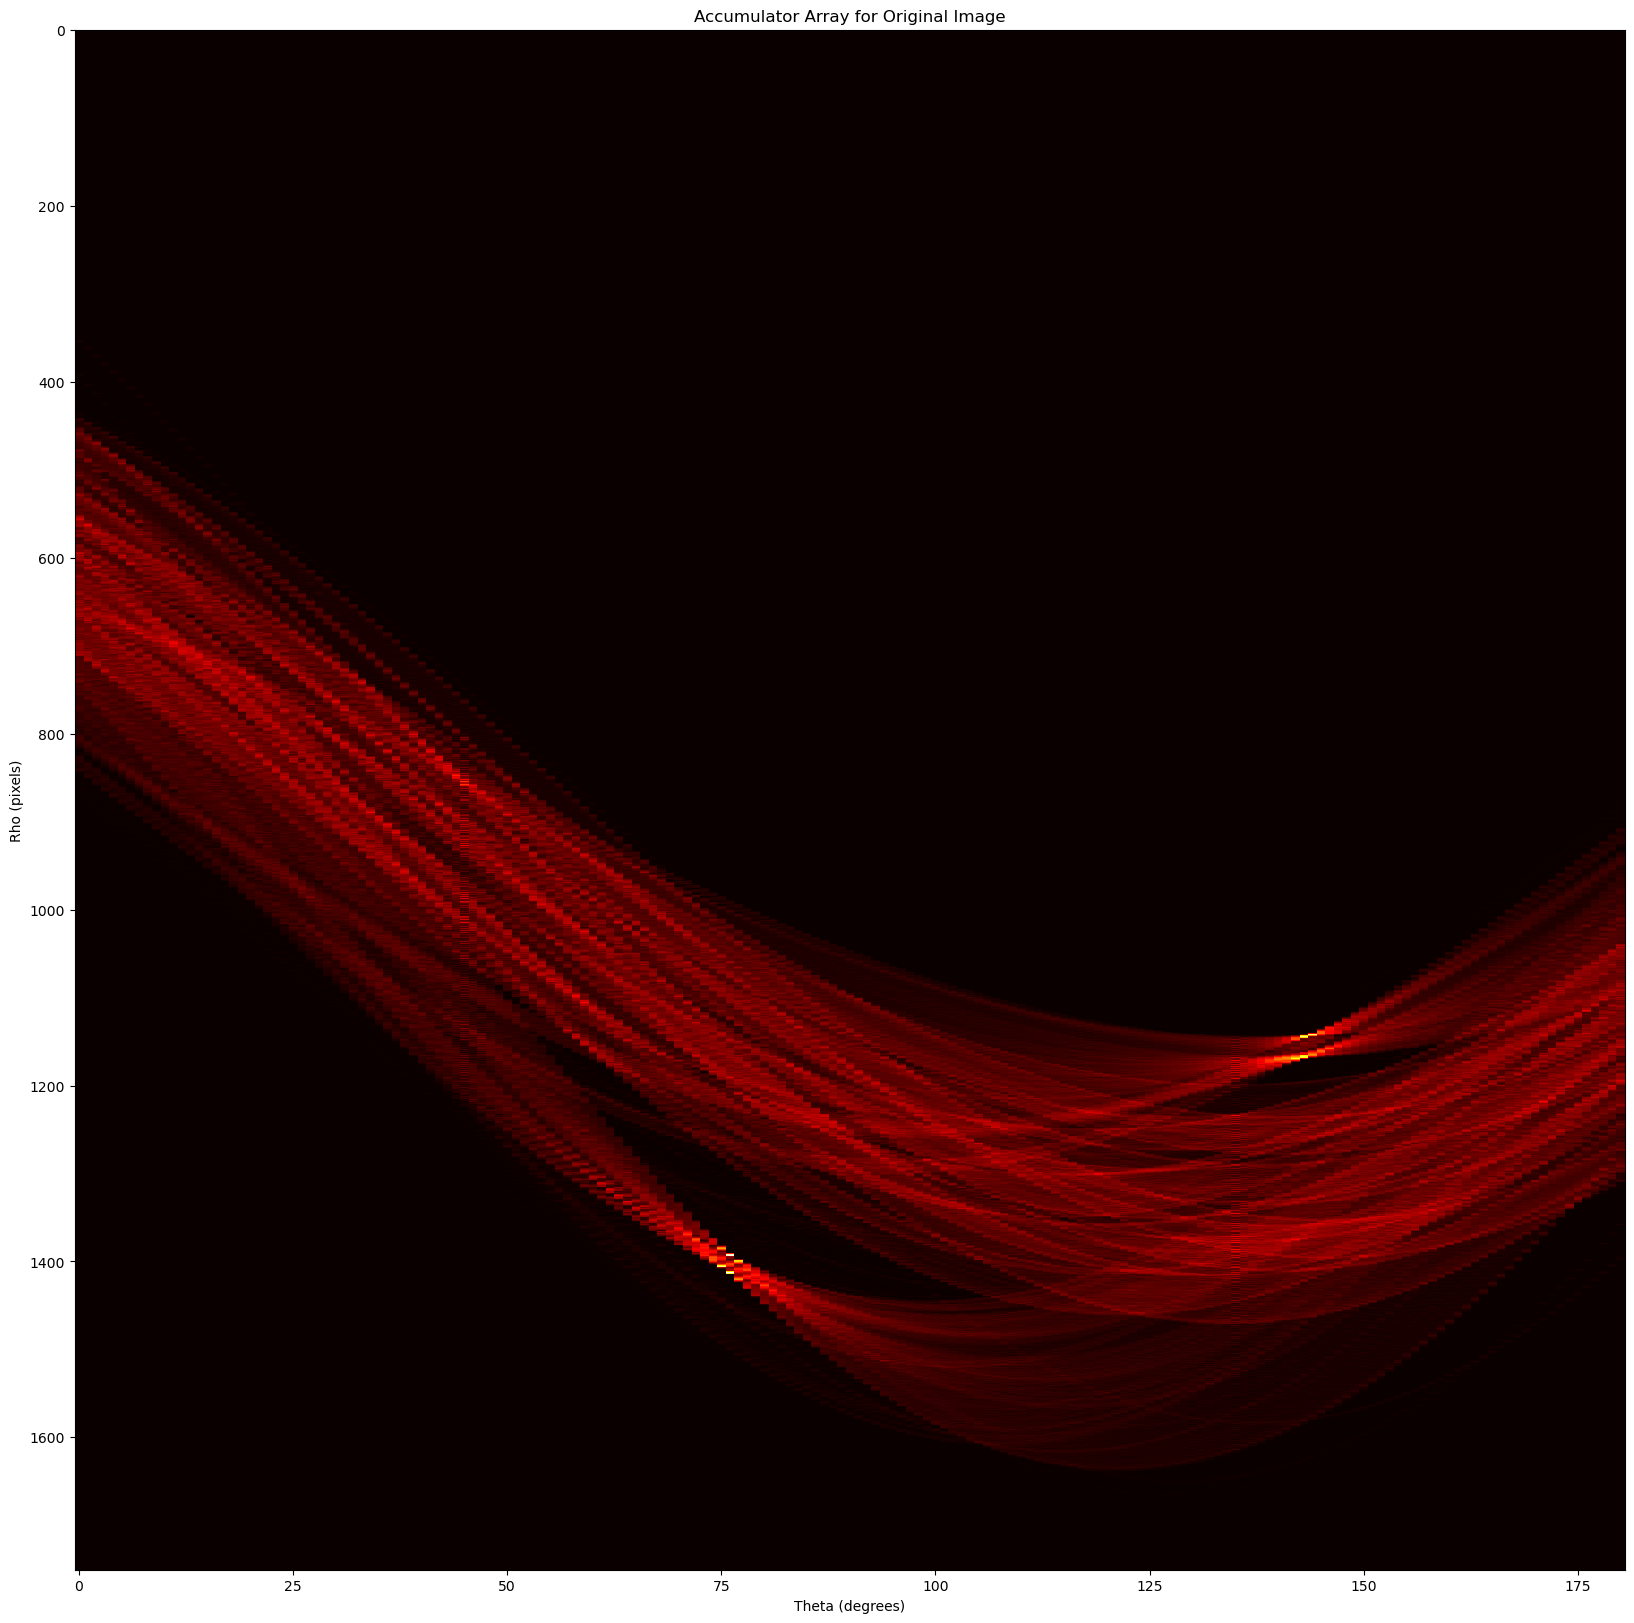

In [9]:
# Invoke the Hough Transform Method to Extract the Lines from the Image
# You need to find a reasonable estimate of the threshold for generating a binary image
# which is good enough for the Hough Transform to extract the lines.
# To expedite the process you can play with the resolution of theta and rho
# without compromising the quality of the results.

threshold = 50
theta_res = 1   # degrees
rho_res = 1     

ori_accumulator, ori_thetas, ori_rhos, ori_binary_img = hough_transform(
    img_gray_edge,   # input from edge detector on original image
    threshold,   # students should tune
    theta_res,
    rho_res
)

# Save the Thresholded Binary Image
cv.imwrite('../results/Ques_1/Ori_Clean_Binary_Image.png', ori_binary_img)

# Plot the Binary Image
plt.figure()
plt.imshow(ori_binary_img.astype(np.uint8), cmap='gray')
plt.title('Binary Image')
plt.axis('off')

# Plot Accumulator Array
############################
plt.figure(figsize=(20, 20))
plt.imshow(ori_accumulator, cmap='hot', interpolation='none', aspect='auto')
plt.title('Accumulator Array for Original Image')
plt.xlabel('Theta (degrees)')
plt.ylabel('Rho (pixels)')
plt.savefig('../results/Ques_1/Ori_Clean_Image_Accumulator_Array.png')
plt.show()
############################
### Your Implementation ENDS here ###
############################

For plotting lines (infinite) in the images, you should use the OpenCV <b>line</b> function which can hold all the lines and then you could overlay them on the input image.

**Hint:**
    To draw the infinite lines using OpenCV’s `line` function, you need to provide the start and end points for each line. The intersection points between the lines and the image boundary (edges of the image) can be used as start and end points. A common approach is to compute the x and y coordinates for these intersection points by solving for `x` and `y` in terms of `rho` and `theta` (from the Hough space). Once you have these coordinates, you can pass them to the OpenCV `line` function to overlay the lines on the input image.

In [10]:
def plot_lines(img_path, accumulator, thetas, rhos, acc_threshold, save_path):
    '''
    This function plots infinite lines detected by the Hough Transform.

    Input:
        img_path : str
            Path to the RGB image on which lines will be drawn.
        accumulator : np.ndarray
            Hough accumulator array.
        thetas : np.ndarray
            Vector of angle values.
        rhos : np.ndarray
            Vector of rho values (perpendicular distances).
        acc_threshold : int
            Threshold value for selecting lines from the accumulator.
        save_path : str
            Path to save the output image with lines drawn.

    Output:
        None
        The function saves the output image (with lines drawn) to save_path.
    '''
    ############################
    ### TODO: Your Implementation ###

    max_lines = 100
    img = cv.imread(img_path)
    img_lines = img.copy()

    # Get candidate indices above threshold
    indices = np.argwhere(accumulator > acc_threshold)
    values = accumulator[indices[:,0], indices[:,1]]

    # Sort by accumulator strength
    sorted_idx = np.argsort(-values)
    indices = indices[sorted_idx[:max_lines]]  # keep only top N

    for rho_idx, theta_idx in indices:
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        length = max(img.shape[0], img.shape[1])
        x1 = int(x0 + length * (-b))
        y1 = int(y0 + length * (a))
        x2 = int(x0 - length * (-b))
        y2 = int(y0 - length * (a))
        cv.line(img_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)


    # Save and display
    cv.imwrite(save_path, img_lines)
    plt.figure(figsize=(8, 8))
    plt.imshow(cv.cvtColor(img_lines, cv.COLOR_BGR2RGB))
    plt.title("Detected Lines")
    plt.axis("off")
    plt.show()

    ############################
    ### Your Implementation ENDS here ###
    ############################

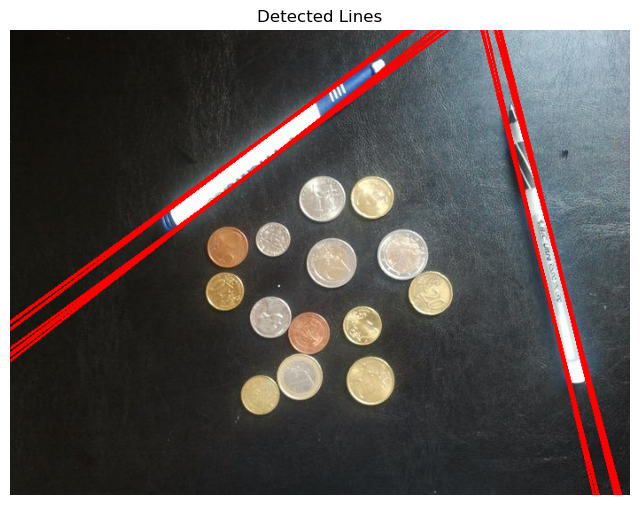

In [11]:
# Plot the lines extracted on the Original Image
# Adjust the accumulator threshold to filter out weak or unwanted lines
acc_threshold = 170   # Example value, students should tune this

plot_lines(
    img_path='../data/proj2-clean-image.jpg',
    accumulator=ori_accumulator,
    thetas=ori_thetas,
    rhos=ori_rhos,
    acc_threshold=acc_threshold,
    save_path='../results/Ques_1/Ori_Clean_Image_Output_Lines.png'
)

#### 1.3.2 Hough Transform to detect Lines from the Smooth Image

Use the edges detected from the <b>smooth input image</b> to apply Hough Transform function.<br>
<br>

You need to find a resaonable estimate of the threshold for generating the binary image which is good enough for the Hough transform to extract lines. Please discuss the effect of the threshold on the performance of the algorithm.

Plot the Accumulator Array using the matplotlib function, figure size (20, 20), with proper labeling and title. The image should be saved as <b>Smooth_Clean_Image_Accumulator_Array.png</b> in results directory.

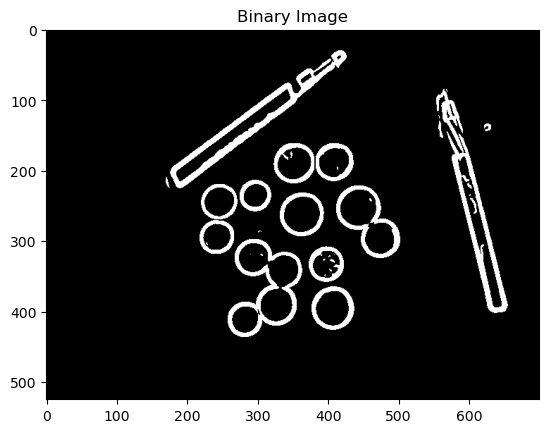

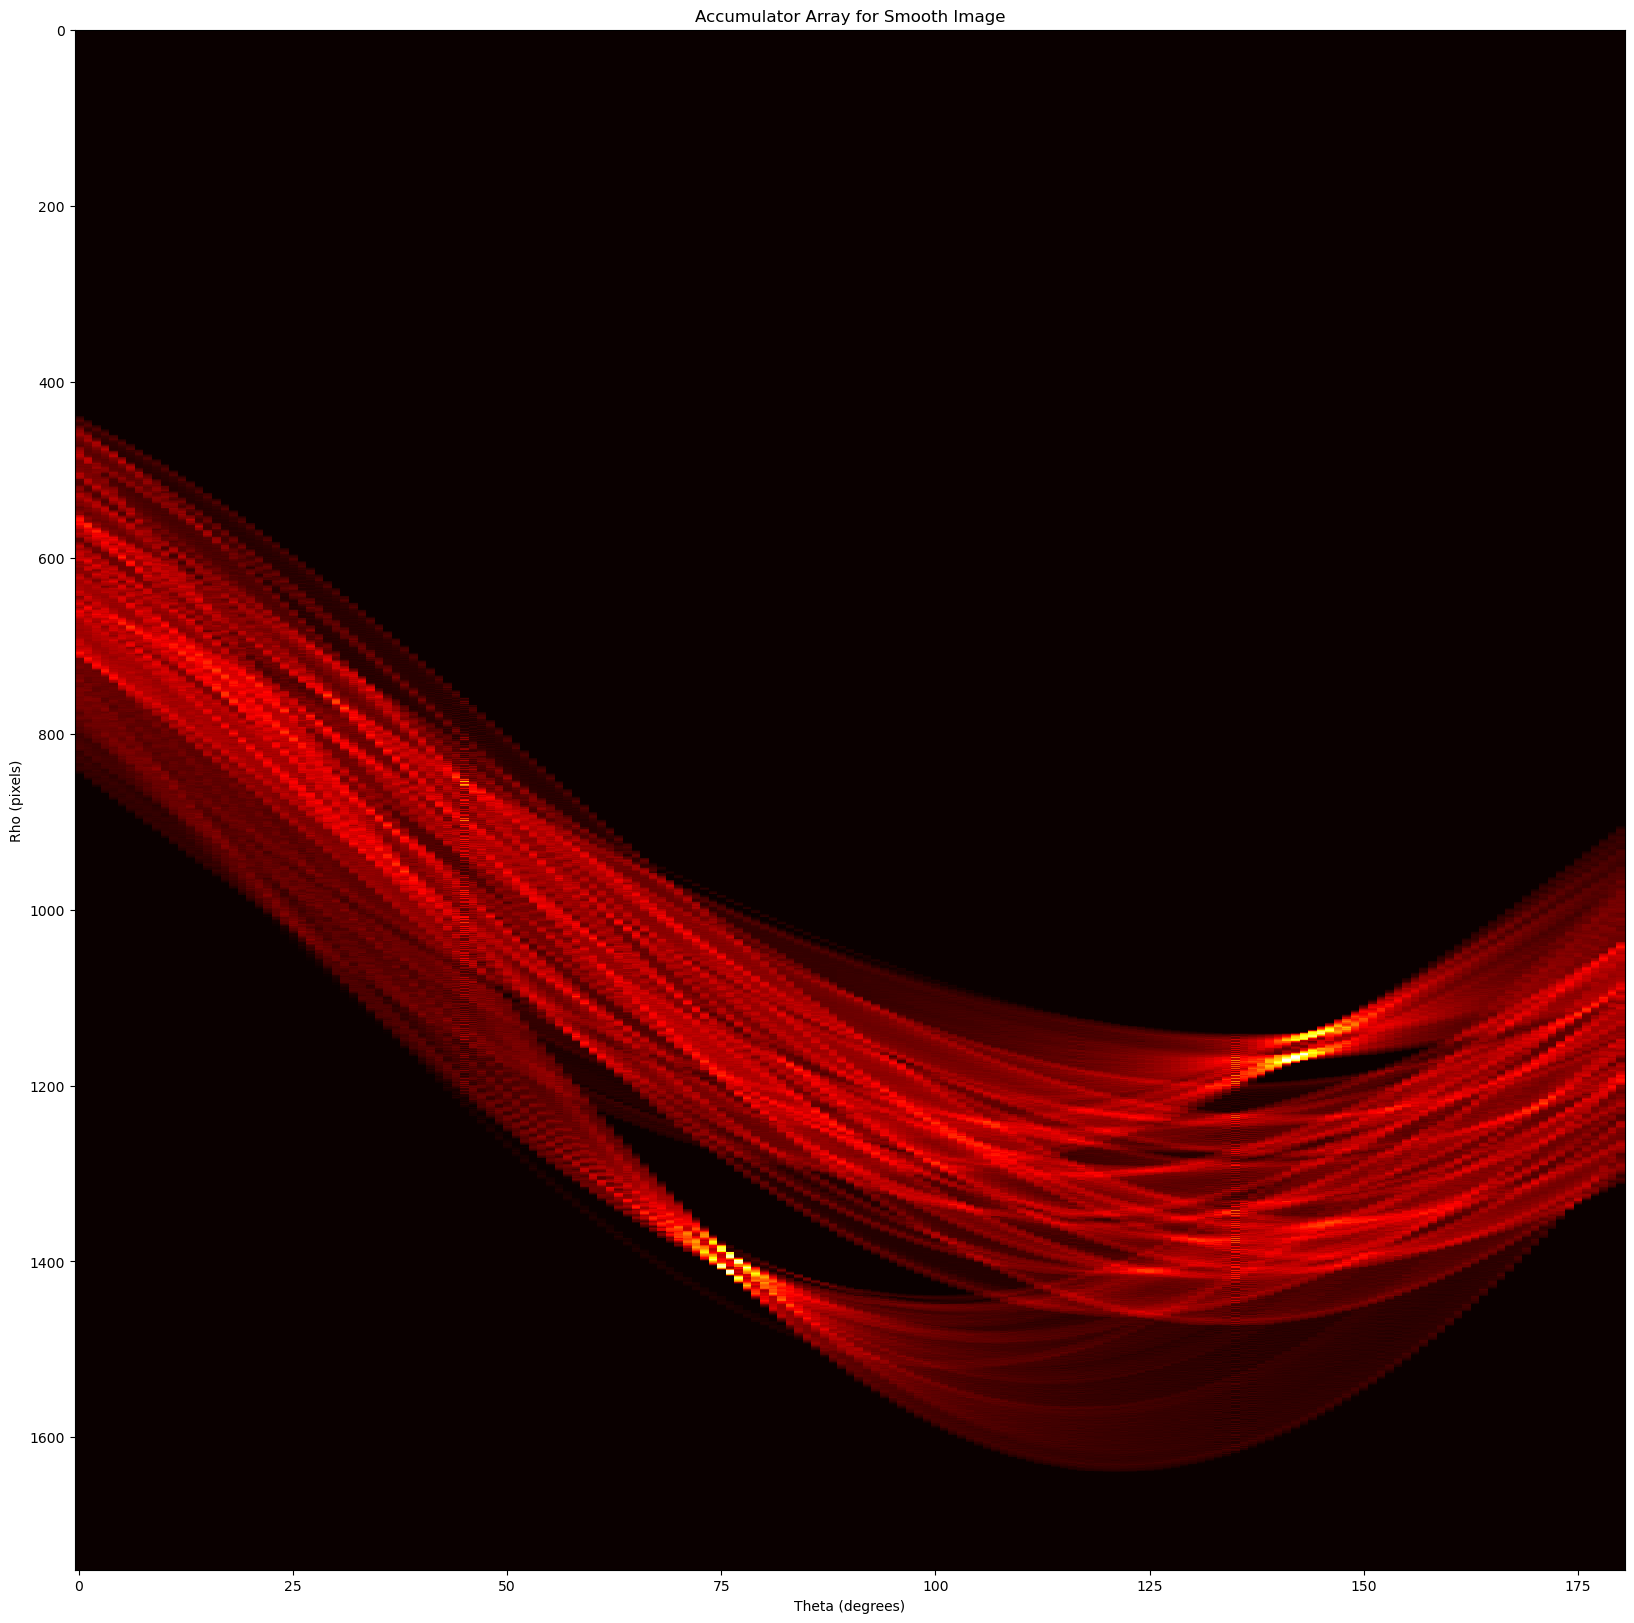

In [12]:
# Invoke the Hough Transform Method to Extract the Lines from the Image
# You need to find a resaonable estimate of the threshold for generating a binary image
# which is good enough for the Hough transform to extract the lines
# To expedite the process you can play with the resolution of the theta and rho 
# without compromising the quality of the results

smooth_img_gray_edge = cv.cvtColor(smooth_img_gray_edge, cv.COLOR_BGR2GRAY)
smooth_accumulator, smooth_thetas, smooth_rhos, smooth_binary_img = hough_transform(
    smooth_img_gray_edge, threshold, theta_res, rho_res
)

# Save the Thresholded Binary Image
cv.imwrite('../results/Ques_1/Smooth_Clean_Binary_Image.png', smooth_binary_img)

# Plot the Binary Image
plt.figure()
plt.imshow(smooth_binary_img.astype(np.uint8), cmap='gray')
plt.title('Binary Image')

# Plot Accumulator Array
############################
# TO DO: Your Implementation
############################
plt.figure(figsize=(20, 20))
plt.imshow(smooth_accumulator, cmap='hot', interpolation='none', aspect='auto')
plt.title('Accumulator Array for Smooth Image')
plt.xlabel('Theta (degrees)')
plt.ylabel('Rho (pixels)')
plt.savefig('../results/Ques_1/Smooth_Clean_Image_Accumulator_Array.png')
plt.show()
############################
# Your Implementation ENDS here
############################

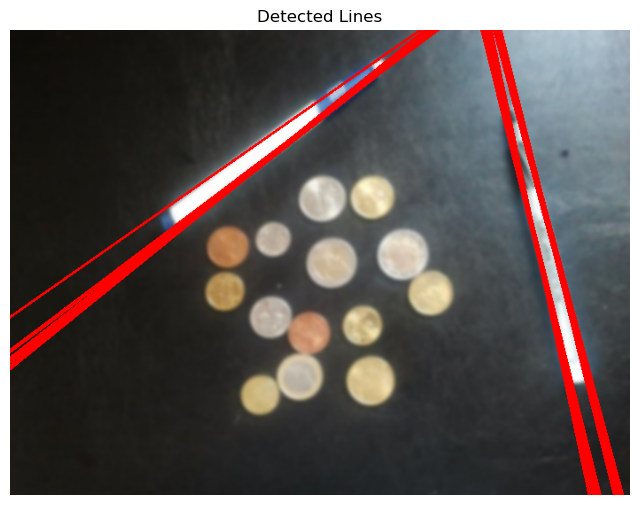

In [13]:
# Plot the Lines extracted on the Smooth Image
# Play with the Accumulator Thresholding to get rid of the unwanted lines

acc_threshold = 260

plot_lines(
    '../results/Ques_1/proj2-clean-image-smoothed.png',
    smooth_accumulator,
    smooth_thetas,
    smooth_rhos,
    acc_threshold,
    save_path='../results/Ques_1/Smooth_Clean_Image_Output_Lines.png'
)

#### 1.4 Hough Transform to detect Edges

Plot the Edges instead of Lines (infinite) along the boundary of the pens.

you should use the OpenCV <b>line</b> function which can hold all the edges and you could then overlay them on the input image.

**Hint:** You can use bitwise operator to find intersections between grayscale images and the drawn lines.

In [14]:
def plot_edges(img_path, accumulator, thetas, rhos, acc_threshold, binary_image, save_path):
    '''
    This function plots edges along the boundary of the pens.

    Input:
    1. RGB image path for plotting edges
    2. Accumulator array
    3. Vector of the angle values (thetas)
    4. Vector of the rho values (rhos)
    5. Threshold value for selecting edges from the accumulator
    6. Binary image (detected edges)
    7. Path to save the image with edges drawn

    Output:
    Returns nothing; saves the output image to save_path.
    '''
    ############################
    # TO DO: Your Implementation
    img = cv.imread(img_path)
    # Copy of the image to draw lines on
    img_edges = img.copy()
    # Get indices of the accumulator array above threshold
    indices = np.argwhere(accumulator > acc_threshold)
    # Get indices of edge pixels
    y_idxs, x_idxs = np.nonzero(binary_image)
    for idx in range(len(indices)):
        rho_idx, theta_idx = indices[idx]
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        # Collect points that lie on this line
        points = []
        for i in range(len(x_idxs)):
            x = x_idxs[i]
            y = y_idxs[i]
            # Check if the point lies on the line
            rho_calculated = x * cos_theta + y * sin_theta
            if abs(rho_calculated - rho) < 1:  # Tolerance value
                points.append((x, y))
        if len(points) > 0:
            # Find extreme points
            points = np.array(points)
            x_coords = points[:, 0]
            y_coords = points[:, 1]
            # Get the endpoints
            x_min_idx = np.argmin(x_coords)
            x_max_idx = np.argmax(x_coords)
            y_min_idx = np.argmin(y_coords)
            y_max_idx = np.argmax(y_coords)
            # Draw line segment
            cv.line(img_edges, (x_coords[x_min_idx], y_coords[x_min_idx]), (x_coords[x_max_idx], y_coords[x_max_idx]), (0, 255, 0), 2)
    # Save the image
    cv.imwrite(save_path, img_edges)
    plt.imshow(cv.cvtColor(img_edges, cv.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    
    ############################
    # Your Implementation ENDS here
    ############################

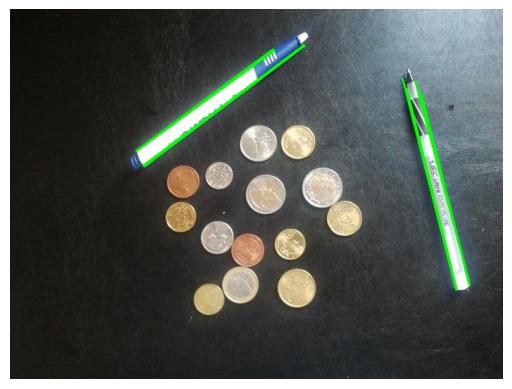

In [63]:
# Plot the Boundaries of the Pen on the Real Image
# This unlike the previous result is restricted to a finite length line
# Play with the Accumulator Thresholding to get rid of the unwanted lines

acc_threshold = 190

plot_edges(
    '../data/proj2-clean-image.jpg',
    ori_accumulator,
    ori_thetas,
    ori_rhos,
    acc_threshold,
    ori_binary_img,
    save_path='../results/Ques_1/Ori_Clean_Image_Output_Edges.png'
)

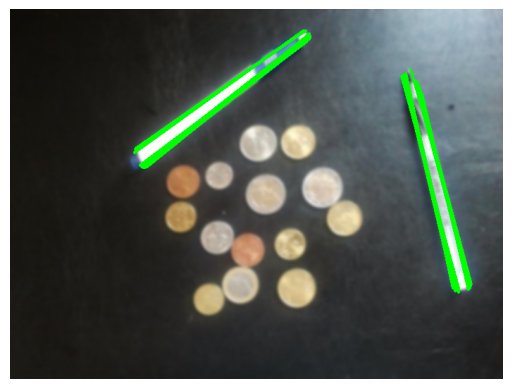

In [16]:
# Plot the Boundaries of the Pen on the Smooth Image
# This unlike the previous result is restricted to a finite length line
# Play with the Accumulator Thresholding to get rid of the unwanted lines

acc_threshold = 250

plot_edges(
    '../results/Ques_1/proj2-clean-image-smoothed.png',
    smooth_accumulator,
    smooth_thetas,
    smooth_rhos,
    acc_threshold,
    smooth_binary_img,
    save_path='../results/Ques_1/Smooth_Clean_Image_Output_Edges.png'
)

### 2. Hough Transform to detect Circles (20 points)
In this exercise you are expected to implement Hough Transform for circle detection in images as discussed in class. Hough Transform uses an accumulator array to capture the circles present in image. As a circle could be defined with three parametrs, center (along X and Y axis) and radius, we need a three-dimensional accumulator to store the circle information.

#### Tasks:
1. Hough Transform to detect circles from the Images <b>(14 points)</b>
2. Plot the detected circles on the corresponding images <b>(6 points)</b>

You need to perform the task on the <b>Original Image</b> and <b>Smooth Image</b> computed earlier.

It is applied on <b>binary images</b> which can be generated by thresholding the edge detector output.<br>
You should use the result of the previous edge detection task as input for this exercise.

<b>The center of the circle should be computed using the parametric equations.</b>

In [17]:
def circle_hough_transform(input_img, threshold, min_radius, max_radius, radius_res, angle_res):
    '''
    This function computes the accumulator array with the circles detected in the image

    Input:
    1. Output of the Edge Detection Method
    2. Threshold value for generating the binary image
    3. Min Radius of the Circle to be detected
    4. Max Radius of the Circle to be detected
    5. Resolution for Circle Radius
    6. Angle resolution for parametric equation of circle

    Output:
    1. Accumulator array       , declare as accumulator
    2. Array for Circle Center , declare as center_x_vector, center_y_vector
    3. Array for Radius of Circle , declare as radius_vector
    4. Thresholded Binary Image   , declare as binary_img
    '''
    ############################
    # TO DO: Your Implementation
    ############################

    _, binary_img = cv.threshold(input_img, threshold, 255, cv.THRESH_BINARY)
    # Get image dimensions
    height, width = binary_img.shape
    # Define the radius vector
    radius_vector = np.arange(min_radius, max_radius + radius_res, radius_res)
    # Define the angle vector in radians
    angle_vector = np.deg2rad(np.arange(0, 360, angle_res))
    # Create the accumulator array
    accumulator = np.zeros((height, width, len(radius_vector)), dtype=np.uint64)
    # Find indices of edge pixels
    y_idxs, x_idxs = np.nonzero(binary_img)
    # For each edge pixel
    for idx in range(len(x_idxs)):
        x0 = x_idxs[idx]
        y0 = y_idxs[idx]
        # For each radius
        for r_idx, radius in enumerate(radius_vector):
            # Pre-compute cos and sin values for the current radius
            cos_theta = radius * np.cos(angle_vector)
            sin_theta = radius * np.sin(angle_vector)
            # Compute potential center positions
            a = x0 - cos_theta
            b = y0 - sin_theta
            # Round to nearest integer coordinates
            a = np.round(a).astype(int)
            b = np.round(b).astype(int)
            # Filter valid center positions within image bounds
            valid_idxs = (a >= 0) & (a < width) & (b >= 0) & (b < height)
            a = a[valid_idxs]
            b = b[valid_idxs]
            # Update the accumulator array
            accumulator[b, a, r_idx] += 1
    # Define center vectors
    center_x_vector = np.arange(width)
    center_y_vector = np.arange(height)
    ############################
    # Your Implementation ENDS here
    ############################

    return accumulator, radius_vector, center_x_vector, center_y_vector, binary_img

#### 2.1.1 Hough Transform to detect Circles from the Original Image

Use the edges detected from the <b>original input image</b> to apply Hough Transform function.<br>

You need to find a reasonable estimate of the threshold for generating the binary image which is good enough for the Hough transform to extract circles. Please discuss the effect of the threshold on the performance of the algorithm.

##### Please note that you should be able to extract atleast 7 coins. This ensures 75% of the credit.

(-0.5, 699.5, 524.5, -0.5)

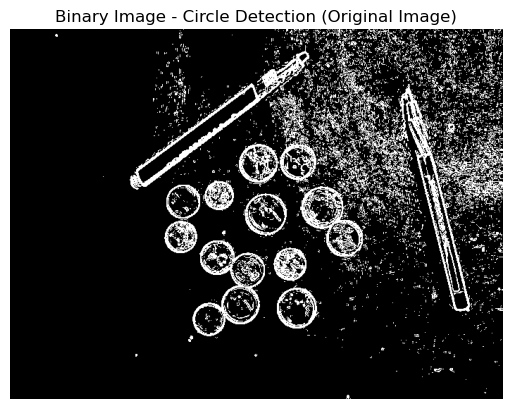

In [18]:
# Invoke the Hough Transform Method to Extract the Circles from the Image
# To expedite the process you can play with the resolution parameters 
# without compromising the quality of the results

# threshold = 80
# min_radius = 25
# max_radius = 60
# radius_res = 1
# angle_res = 3
# acc_threshold = 85

threshold = 20       # Threshold for binary image
min_radius = 20      # Minimum radius to detect
max_radius = 40      # Maximum radius to detect
radius_res = 2       # Radius resolution
angle_res = 3        # Angle resolution in degrees

ori_circle_accumulator, ori_circle_radius_vector, ori_circle_center_x_vector, ori_circle_center_y_vector, ori_circle_img_bin = circle_hough_transform(
    img_gray_edge, threshold, min_radius, max_radius, radius_res, angle_res
)

# Save the Thresholded Binary Image
cv.imwrite('../results/Ques_2/Ori_Clean_Binary_Image_Circle_Detection.png', ori_circle_img_bin)

# Plot the Binary Image
plt.figure()
plt.imshow(ori_circle_img_bin.astype(np.uint8), cmap='gray')
plt.title('Binary Image - Circle Detection (Original Image)')
plt.axis('off')

#### 2.1.2 Hough Transform to detect Circles from the Smooth Image

Use the edges detected from the <b>smooth input image</b> to apply Hough Transform function or generate a suitable smooth image (following the same procedure) for this exercise to detect coins. If you generate a new smooth image please save the generated image as <b>proj2-clean-image-smoothed-circle-detection.png</b>.<br>

You should explain the reason for generating a new smooth image, report the value of sigma and discuss its effect on the performance of the circle detection algorithm.<br>
<br>
You need to find a resaonable estimate of the threshold for generating the binary image
which is good enough for the Hough transform to extract circles. Please discuss the effect of the threshold on the performance of the algorithm.<br>

##### Please note that you should be able to extract atleast 7 coins. This ensures 75% of the credit.

(-0.5, 699.5, 524.5, -0.5)

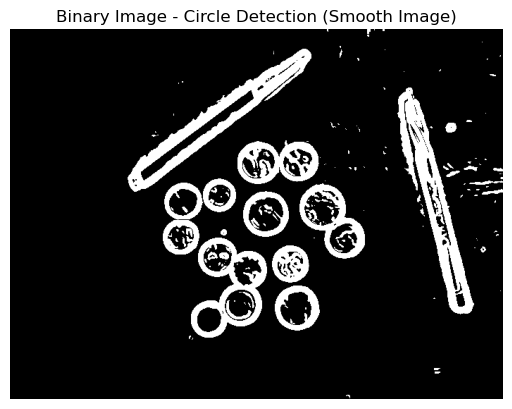

In [19]:
# Invoke the Hough Transform Method to Extract the Circles from the Image
# You need to find a resaonable estimate of the threshold for generating a binary image
# which is good enough for the Hough transform to extract circles
# To expedite the process you can play with the resolution parameters 
# without compromising the quality of the results

smooth_circle_accumulator, smooth_circle_radius_vector, smooth_circle_center_x_vector, smooth_circle_center_y_vector, smooth_circle_img_bin = circle_hough_transform(
    smooth_img_gray_edge, threshold, min_radius, max_radius, radius_res, angle_res
)

# Save the Thresholded Binary Image
cv.imwrite('../results/Ques_2/Smooth_Clean_Binary_Image_Circle_Detection.png', smooth_circle_img_bin)

# Plot the Binary Image
plt.figure()
plt.imshow(smooth_circle_img_bin.astype(np.uint8), cmap='gray')
plt.title('Binary Image - Circle Detection (Smooth Image)')
plt.axis('off')

#### 2.2 Plot the Circles around the coins in the image
You should use the OpenCV <b>circle</b> function for drawing circles. This can hold all the circles and then you could overlay them on the input image.

In [20]:
def plot_circles(img_path, accumulator, radius_vector, center_x_vector, center_y_vector, acc_threshold, bin_image, img_save_path):
    '''
    This function plots circles
    This should be used to draw circles around the coins in the image

    Input:
    1. RGB Image for plotting circles
    2. Accumulator array
    3. Vector of the radius values
    4. Vector of the center of the circle
    5. Threshold value for selecting circles from the accumulator
    6. Path to save the image with circles drawn on them

    Output:
    Returns Nothing
    Saves the output image in img_save_path
    '''

    ############################
    # TO DO: Your Implementation
    ############################

    # Load the image
    cv_img = cv.imread(img_path)
    # Copy of the image to draw circles on
    img_circles = cv_img.copy()
    # Find indices in the accumulator array where votes exceed the threshold
    indices = np.argwhere(accumulator > acc_threshold)
    # Draw circles
    MAX_CIRCLES_TO_PLOT = 20
    values = accumulator[indices[:,0], indices[:,1], indices[:,2]]
    # Sort indices by accumulator strength (descending)
    sorted_idx = np.argsort(-values)
    indices = indices[sorted_idx[:MAX_CIRCLES_TO_PLOT]]
    
    for idx in range(len(indices)):
        y_idx, x_idx, r_idx = indices[idx]
        center_x = x_idx
        center_y = y_idx
        radius = radius_vector[r_idx]
        # Draw the circle
        cv.circle(img_circles, (center_x, center_y), int(radius), (0, 255, 0), 2)
    # Save the image
    cv.imwrite(img_save_path, img_circles)

    ############################
    # Your Implementation ENDS here
    ############################

    # All the changes made in the input image are finally
    # written on a new file
    #cv.imwrite(img_save_path, cv_img)
    plt.imshow(cv.cvtColor(img_circles, cv.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

#### 2.2.1 Plot the Circles around the coins in the Original Image

Play with the Accumulator Thresholding to get rid of unwanted circles.


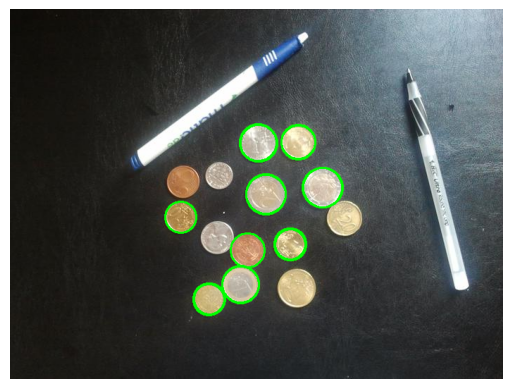

In [21]:
# Plot the Circles extracted on the Original Image
acc_threshold = 100

plot_circles(
    '../data/proj2-clean-image.jpg',
    ori_circle_accumulator,
    ori_circle_radius_vector,
    ori_circle_center_x_vector,
    ori_circle_center_y_vector,
    acc_threshold,
    ori_circle_img_bin,
    '../results/Ques_2/Ori_Clean_Image_Output_Circles.png'
)

#### 2.2.2 Plot the Circles around the coins in the Smooth Image

Play with the Accumulator Thresholding to get rid of unwanted circles.


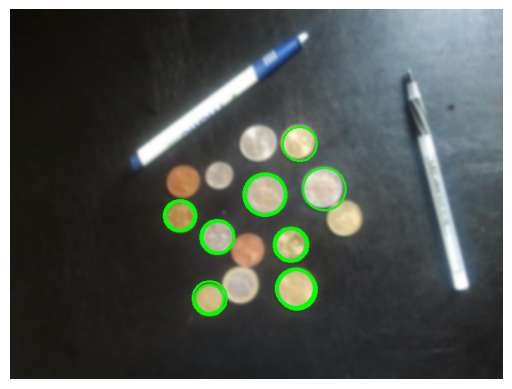

In [22]:
# Plot the Circles extracted on the Smooth Image
acc_threshold = 70

plot_circles(
    '../results/Ques_1/proj2-clean-image-smoothed.png',
    smooth_circle_accumulator,
    smooth_circle_radius_vector,
    smooth_circle_center_x_vector,
    smooth_circle_center_y_vector,
    acc_threshold,
    smooth_circle_img_bin,
    '../results/Ques_2/Smooth_Clean_Image_Output_Circles.png'
)

### 3 Hough Transform to detect Lines from Cluttered Image (22 points)
In this exercise you are expected to implement Hough Transform for line detection from cluttered image. Hough Transform uses an accumulator array to capture the lines present in image. It is applied on binary images which can be generated by thresholding the edge detector output.

#### Tasks:
1. Smooth the given image using the Gaussian Filter. Determine the Gaussian filter and comment on its effect in determining the lines. Save the smooth image as <b>clutter_smooth_img</b>, numpy array. <b>(3 points)</b>
2. Identify the edges in the smooth image, generated in the previous step. You can use the solution of <b>Ques 1.2</b>. Save the numpy array as <b>clutter_smooth_img_gray_edge</b>. <b>(3 points)</b>
3. Identify the lines in the Image using Hough Transform. <b>(3 points)</b>
4. Draw the detected lines. <b>(3 points)</b>
5. Likely the last produced several lines which DO NOT repesent the boundary of the pens. How do you take care of the probem? <b>(5 points)</b>
6. Find the lines which represents only the boundary of the pens. <b>(5 points)</b>

#### 3.1 Smooth the given image using the Gaussian Filter. Determine the Gaussian filter and comment on its effect in determining the lines. Save the smooth image as clutter_smooth_img, numpy array.

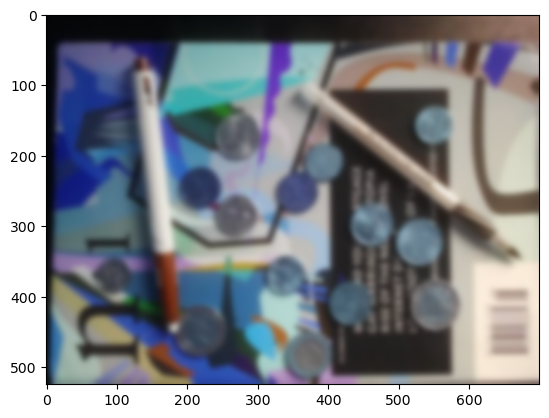

In [23]:
# Reading the Input Image
clutter_img = cv.imread('../data/proj2-clutter-image.jpg')

############################
# TO DO: Your Implementation
############################
sigma = 4  # reduce noise while preserving edges

# Generate the Gaussian Filter
g_kernel = Gaussian_Filter(sigma)

# Smooth the image
clutter_smooth_img = cv.filter2D(clutter_img, -1, g_kernel)
############################
# Your Implementation ENDS here
############################

# Saves the Smooth Image in the result directory
cv.imwrite("../results/Ques_3/clutter_smooth_img.png", clutter_smooth_img)

# Plots the smoothed image in the notebook
plt.figure()
plt.imshow(clutter_smooth_img.astype(np.uint8), cmap='gray')

#### 3.2 Identify the edges in the smooth image, generated in the previous step. You can use the solution of Ques 1.2. Save the numpy array as clutter_smooth_img_gray_edge.

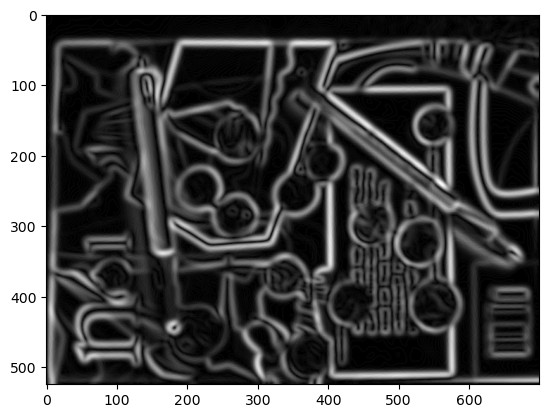

In [24]:
############################
# TO DO: Your Implementation
############################
clutter_smooth_img_gray = cv.cvtColor(clutter_smooth_img, cv.COLOR_BGR2GRAY)
clutter_smooth_img_gray_edge = detect_edges_with_sobel(clutter_smooth_img_gray)
############################
# Your Implementation ENDS here
############################

# Save the Image
cv.imwrite('../results/Ques_3/clutter_smooth_img_gray_edge.png', clutter_smooth_img_gray_edge)

# Plot the Image
plt.figure()
plt.imshow(clutter_smooth_img_gray_edge.astype(np.uint8), cmap='gray')

#### 3.3 Identify the lines in the Image using Hough Transform

Text(0.5, 1.0, 'Binary Image')

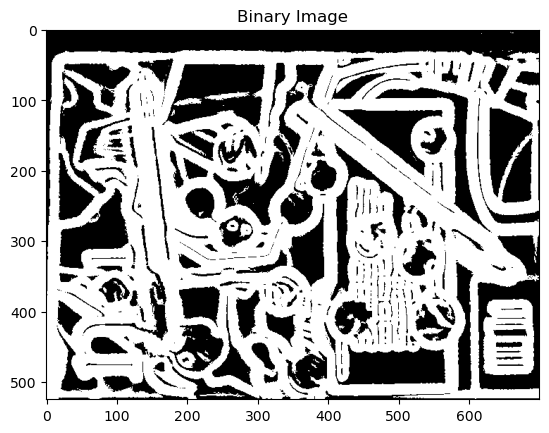

In [25]:
# Invoke the Hough Transform Method to Extract the Lines from the Image
# You need to find a reasonable estimate of the threshold for generating a binary image
# which is good enough for the Hough transform to extract the lines
# To expedite the process you can play with the resolution of the theta and rho 
# without compromising the quality of the results

clutter_smooth_accumulator, clutter_smooth_thetas, clutter_smooth_rhos, clutter_smooth_binary_img = hough_transform(
    clutter_smooth_img_gray_edge, threshold, theta_res, rho_res
)

# Save the Thresholded Binary Image
cv.imwrite('../results/Ques_3/Clutter_Smooth_Binary_Image.png', clutter_smooth_binary_img)

# Plot the Binary Image
plt.figure()
plt.imshow(clutter_smooth_binary_img.astype(np.uint8), cmap='gray')
plt.title('Binary Image')

#### 3.4 Draw the detected lines

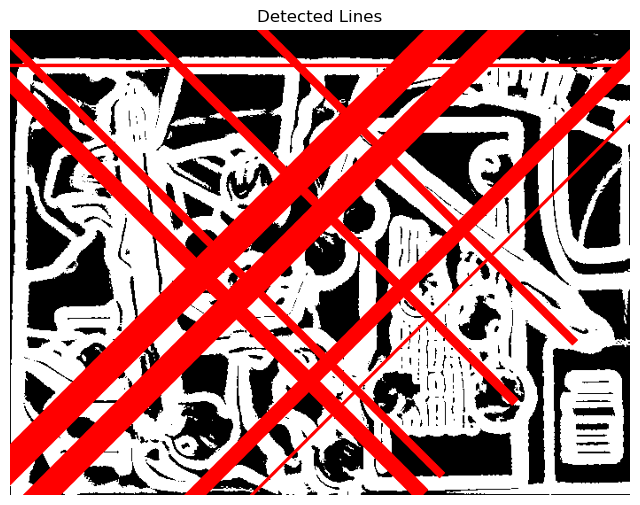

In [57]:
# Plot the Lines extracted on the Cluttered Smooth Image
# Play with the Accumulator Thresholding to get rid of the unwanted lines
acc_threshold = 660

plot_lines(
    '../results/Ques_3/Clutter_Smooth_Binary_Image.png',
    clutter_smooth_accumulator,
    clutter_smooth_thetas,
    clutter_smooth_rhos,
    acc_threshold,
    save_path='../results/Ques_3/Clutter_Smooth_Image_Output_Lines.png'
)

#### 3.5 Most likely the last exercise produced several lines which DO NOT repesent the boundaries of the pens. How do you take care of the problem? Discuss.

Extra edges and points in the image cause these lines to appear. One way to reduce this is to smoothen the image slightly, for example with the Gaussian filter as we do. This would smoothen out rough edges and only have the necessary edges appear. Another method we use is to use a threshold and only keep the strong edges. This helps reduce extra edges.

#### 3.6 Find the edges which represents only the boundaries of the pens and plot it on the smooth version of the clutter image. 
You need to write a function similar to plot_edges() (but NOT the same).  You will need to check the length of each segment of the line and select only the ones that are above a certain threshold length.  

Save the output image as <b>'../results/Ques_3/Clutter_Smooth_Image_Output_Edges.png'</b>

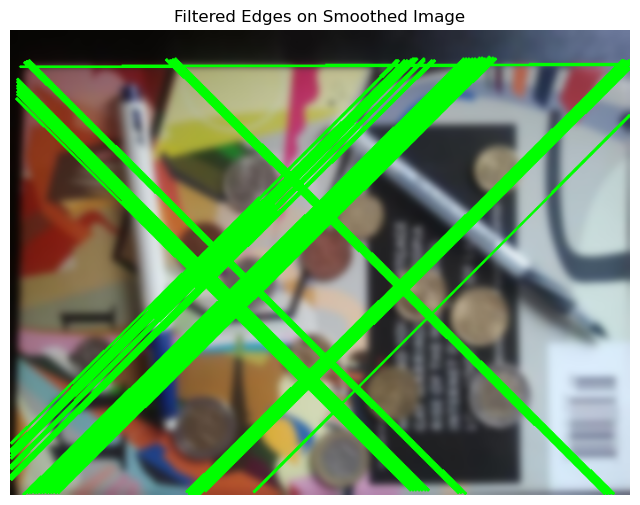

In [60]:
##############################
# TO DO: Your Implementation
##############################
def plot_long_edges(img_path, accumulator, thetas, rhos, acc_threshold, binary_image, length_threshold, save_path):
    '''
    This function plots edges with length above a certain threshold
    This should be used to draw edges along the boundary of the pens

    Input:
    1. RGB Image for plotting lines
    2. Accumulator array
    3. Vector of the angle values
    4. Vector of the rho values
    5. Threshold value for selecting lines from the accumulator
    6. Binary image used for edge detection
    7. Length threshold for line segments
    8. Path to save the image with lines drawn on them

    Output:
    Returns Nothing
    Saves the output image in save_path
    '''

    max_lines = 100
    # Load the image
    img = cv.imread(img_path)
    img_edges = img.copy()

    # Get indices of accumulator cells above threshold
    indices = np.argwhere(accumulator > acc_threshold)

    if len(indices) == 0:
        print("No lines above threshold.")
        cv.imwrite(save_path, img_edges)
        return

    # Sort indices by accumulator strength (descending)
    values = accumulator[indices[:,0], indices[:,1]]
    sorted_idx = np.argsort(-values)
    indices = indices[sorted_idx[:max_lines]]

    # Get edge pixel coordinates (x, y)
    y_idxs, x_idxs = np.nonzero(binary_image)
    edge_points = np.column_stack((x_idxs, y_idxs))

    # For each candidate line
    for rho_idx, theta_idx in indices:
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)

        # Distance of each edge point from the line
        distance = np.abs(edge_points[:, 0] * cos_theta +
                          edge_points[:, 1] * sin_theta - rho)
        line_points = edge_points[distance < 2]  # tolerance of 2 pixels

        if len(line_points) > 0:
            x_coords = line_points[:, 0]
            y_coords = line_points[:, 1]

            # Find endpoints along the axis with the largest spread
            if (x_coords.max() - x_coords.min()) >= (y_coords.max() - y_coords.min()):
                min_x_idx = np.argmin(x_coords)
                max_x_idx = np.argmax(x_coords)
                pt1 = (int(x_coords[min_x_idx]), int(y_coords[min_x_idx]))
                pt2 = (int(x_coords[max_x_idx]), int(y_coords[max_x_idx]))
            else:
                min_y_idx = np.argmin(y_coords)
                max_y_idx = np.argmax(y_coords)
                pt1 = (int(x_coords[min_y_idx]), int(y_coords[min_y_idx]))
                pt2 = (int(x_coords[max_y_idx]), int(y_coords[max_y_idx]))

            # Compute length of the segment
            line_length = np.hypot(pt2[0] - pt1[0], pt2[1] - pt1[1])

            # Draw only if long enough
            if line_length > length_threshold:
                cv.line(img_edges, pt1, pt2, (0, 255, 0), 2)

    # Save the result
    cv.imwrite(save_path, img_edges)

# Length threshold for line segments
length_threshold = 600  # expected length of pen edges

# Plot the edges which represent only the boundaries of the pens
plot_long_edges(
    '../results/Ques_3/clutter_smooth_img.png',
    clutter_smooth_accumulator,
    clutter_smooth_thetas,
    clutter_smooth_rhos,
    acc_threshold,
    clutter_smooth_binary_img,
    length_threshold,
    '../results/Ques_3/Clutter_Smooth_Image_Output_Edges.png'
)

# Display the image with filtered edges
clutter_edges_img = cv.imread('../results/Ques_3/Clutter_Smooth_Image_Output_Edges.png')
plt.figure(figsize=(8,8))
plt.imshow(cv.cvtColor(clutter_edges_img, cv.COLOR_BGR2RGB))
plt.title('Filtered Edges on Smoothed Image')
plt.axis("off")
plt.show()
################################
# Your Implementation ENDS here
################################

### 4. Hough Transform to detect Circles from Cluttered Image (24 points)
In this exercise you are expected to implement Hough Transform for detecting circles from cluttered image. Hough Transform is applied on binary images which can be generated by thresholding the edge detector output.

#### Tasks:
1. Smooth the given image using the Gaussian Filter. Determine the Gaussian filter and comment on its effect in determining the circles. Save the smooth image as <b>clutter_smooth_img_circle_detection</b>, numpy array. <b>(3 points)</b>
2. Identify the edges in the smooth image, generated in the previous step. You can use the solution of <b>Ques 1.2</b>. Save the numpy array as <b>clutter_smooth_img_gray_edge_circle_detection</b>. <b>(3 points)</b>
3. Identify the circles in the Image using Hough Transform. <b>(3 points)</b>
4. Draw the detected circles. <b>(3 points)</b>
5. Did the last solution detect any unwanted circles? If yes, please explain the reason. Which parameters you feel are affecting the result. Moreover, what could be the correct measures to prevent this? <b>(6 points)</b>
6. You are required to find boundaries around atleast 8 coins in the image. <b>(6 points)</b>

#### 4.1 Smooth the given image using the Gaussian Filter. Determine the Gaussian filter and comment on its effect in determining the circles. Save the smooth image as <b>clutter_smooth_img_circle_detection</b>, numpy array.

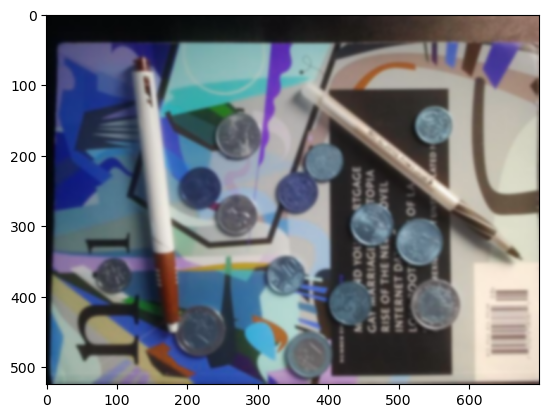

In [28]:
# Reading the Input Image
clutter_img_circle_detection = cv.imread('../data/proj2-clutter-image.jpg')

##############################
# TO DO: Your Implementation
# Apply Gaussian filter on clutter_img_circle_detection 
# to generate clutter_smooth_img_circle_detection
##############################
sigma = 2  # Chosen to reduce noise and small edges

# Generate the Gaussian Filter
g_kernel = Gaussian_Filter(sigma)

# Smooth the image
clutter_smooth_img_circle_detection = cv.filter2D(clutter_img_circle_detection, -1, g_kernel)

################################
# Your Implementation ENDS here
################################

# Save the Smooth Image in the result directory
cv.imwrite("../results/Ques_4/proj2-clutter-image-smoothed_circle_detection.png", clutter_smooth_img_circle_detection)

# Plot the smoothed image in the notebook
plt.figure(); plt.imshow(clutter_smooth_img_circle_detection.astype(np.uint8), cmap='gray');

#### 4.2 Identify the circles in the smooth image, generated in the previous step. You can use the solution of <b>Ques 1.2</b>. 
Save the numpy array as <b>clutter_smooth_img_gray_edge_circle_detection</b>.

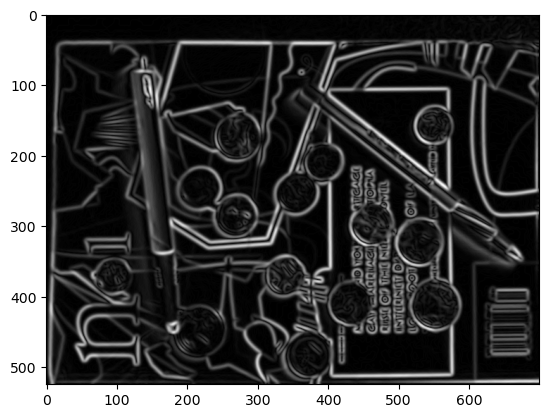

In [29]:
##############################
# TO DO: Your Implementation
# Detect edges from clutter_smooth_img_circle_detection
# Save the result in clutter_smooth_img_gray_edge_circle_detection
##############################
gray_circle_input = cv.cvtColor(clutter_smooth_img_circle_detection,cv.COLOR_BGR2GRAY) # grayscale

clutter_smooth_img_gray_edge_circle_detection = detect_edges_with_sobel(gray_circle_input) # Call sobel function

################################
# Your Implementation ENDS here
################################

# Save the Edge Image
cv.imwrite('../results/Ques_4/Smooth_Clutter_Edge_Image_Circle_Detection.png', clutter_smooth_img_gray_edge_circle_detection)

# Plot the Edge Image
plt.figure(); plt.imshow(clutter_smooth_img_gray_edge_circle_detection.astype(np.uint8), cmap='gray');

#### 4.3 Identify the circles in the Image using Hough Transform

Text(0.5, 1.0, 'Binary Image for Circle Detection')

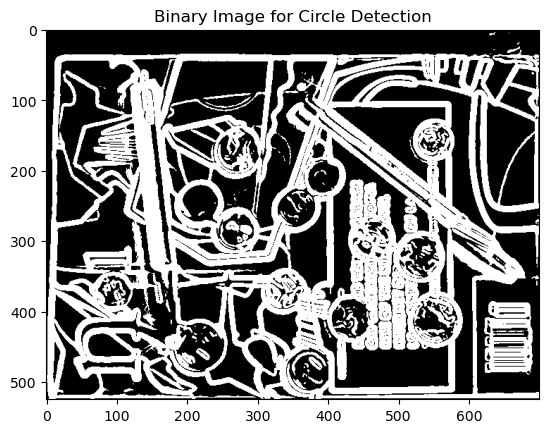

In [30]:
# Invoke the Hough Transform Method to Extract the Circles from the Image
# You need to find a reasonable estimate of the threshold for generating a binary image
# which is good enough for the Hough transform to extract circles
# To expedite the process you can play with the resolution parameters 
# without compromising the quality of the results

clutter_smooth_circle_accumulator, clutter_smooth_circle_radius_vector, clutter_smooth_circle_center_x_vector, clutter_smooth_circle_center_y_vector, clutter_smooth_circle_img_bin = circle_hough_transform(
    clutter_smooth_img_gray_edge_circle_detection, threshold, min_radius, max_radius, radius_res, angle_res
)

# Save the Thresholded Binary Image
cv.imwrite('../results/Ques_4/Smooth_Clutter_Binary_Image_Circle_Detection.png', clutter_smooth_circle_img_bin)

# Plot the Binary Image
plt.figure(); plt.imshow(clutter_smooth_circle_img_bin.astype(np.uint8), cmap='gray'); plt.title('Binary Image for Circle Detection')

#### 4.4 Draw the detected circles

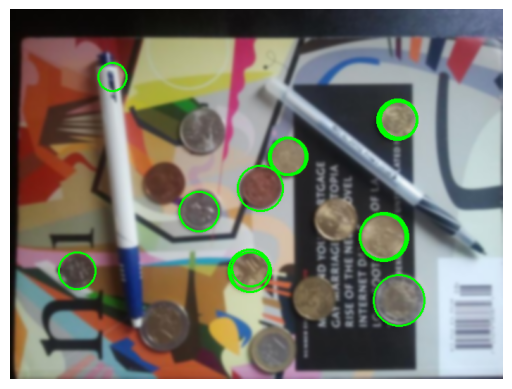

Text(0.5, 1.0, 'Detected Circles on Smooth Clutter Image')

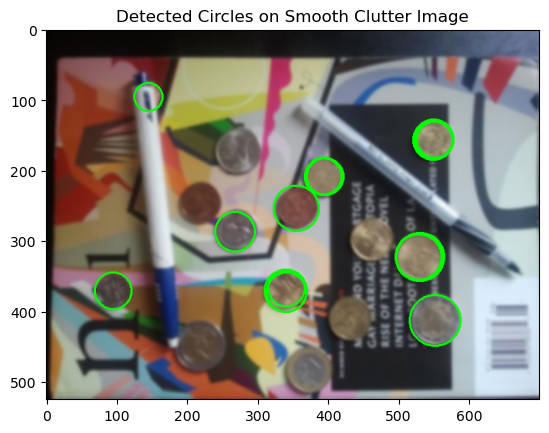

In [31]:
# Plot the Circles extracted on the Smooth Image

acc_threshold = 20

plot_circles(
    '../results/Ques_4/proj2-clutter-image-smoothed_circle_detection.png',
    clutter_smooth_circle_accumulator,
    clutter_smooth_circle_radius_vector,
    clutter_smooth_circle_center_x_vector,
    clutter_smooth_circle_center_y_vector,
    acc_threshold,
    clutter_smooth_circle_img_bin,
    '../results/Ques_4/Smooth_Clutter_Image_Output_Circles.png'
)

plt.figure()
plt.imshow(cv.cvtColor(cv.imread('../results/Ques_4/Smooth_Clutter_Image_Output_Circles.png'), cv.COLOR_BGR2RGB))
plt.title('Detected Circles on Smooth Clutter Image')

#### 4.5 Did the last solution detect any unwanted circles? If yes, please explain the reason. Which parameters you feel are affecting the result. Moreover, what could be the correct measures to prevent this?

It had extra circles over a few coins, but they were not unnecessary. I think drawing fewer circles could be one solution.

#### 4.6 Devise some mechanisms such that you can find boundaries of at least 8 coins in the image

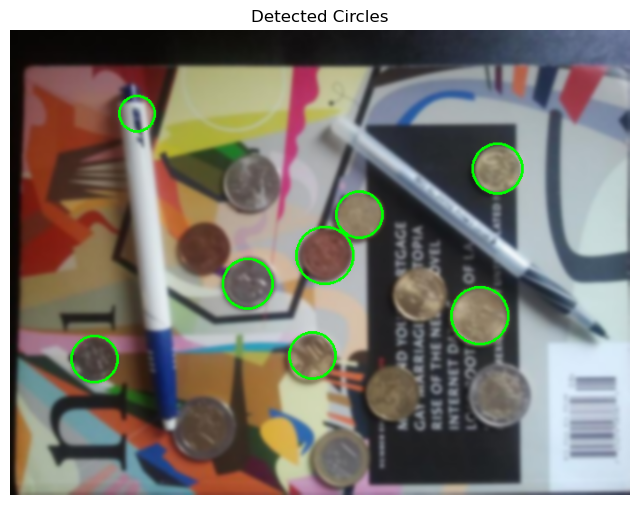

In [32]:
##############################
# TO DO: Your Implementation
##############################

def custom(img_path, accumulator, radius_vector, center_x_vector, center_y_vector, acc_threshold, bin_image):
    '''
    This function plots circles with non-maximum suppression to avoid duplicates
    and limit to at least 8 coins

    Input:
    1. RGB Image for plotting circles
    2. Accumulator array
    3. Vector of the radius values
    4. Vector of the center coordinates
    5. Threshold value for selecting circles from the accumulator
    6. Binary image used for edge detection
    7. Path to save the image with circles drawn on them

    Output:
    Returns Nothing
    '''

    # Load the image
    cv_img = cv.imread(img_path)
    # Copy of the image to draw circles on
    img_circles = cv_img.copy()
    # Find indices in the accumulator array where votes exceed the threshold
    indices = np.argwhere(accumulator > acc_threshold)
    # Collect circles
    circles = []
    for idx in range(len(indices)):
        y_idx, x_idx, r_idx = indices[idx]
        center_x = x_idx
        center_y = y_idx
        radius = radius_vector[r_idx]
        votes = accumulator[y_idx, x_idx, r_idx]
        circles.append((center_x, center_y, radius, votes))
    # Sort circles by votes in descending order
    circles = sorted(circles, key=lambda x: x[3], reverse=True)
    # remove overlapping circles
    selected_circles = []
    for circle in circles:
        x, y, r, v = circle
        too_close = False
        for sc in selected_circles:
            sc_x, sc_y, sc_r, sc_v = sc
            dist = np.hypot(x - sc_x, y - sc_y)
            if dist < sc_r * 0.8:  # Overlap threshold, adjust as needed
                too_close = True
                break
        if not too_close:
            selected_circles.append(circle)
        if len(selected_circles) >= 8:  # Stop after finding 8 circles
            break
    # Draw circles
    for circle in selected_circles:
        center_x, center_y, radius, votes = circle
        # Draw the circle
        cv.circle(img_circles, (center_x, center_y), int(radius), (0, 255, 0), 2)
        
    # display
    rgb_display = cv.cvtColor(img_circles, cv.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_display)
    plt.title('Detected Circles')
    plt.axis('off')
    plt.show()

acc_threshold = 0

# Plot the Circles extracted on the Smooth Image with adjusted parameters and filtering
custom('../results/Ques_4/proj2-clutter-image-smoothed_circle_detection.png', clutter_smooth_circle_accumulator, clutter_smooth_circle_radius_vector, clutter_smooth_circle_center_x_vector, clutter_smooth_circle_center_y_vector, acc_threshold, clutter_smooth_circle_img_bin)



################################
# Your Implementation ENDS here
################################

### 5 Test Robustness to Noise (10 extra points)
In this exercise, we test the robustness of Hough Transform to Gaussian noise.<br>
For this experiment, consider the optimum setting of the parameters (like sigma for smoothing, threshold for binary image, threshold for accumulator and others) for both line and circle detection using Hough Transform.<br>

Then keep adding Gaussian noise to the clutter image, <b>proj2-clutter-image.jpg</b>, starting with sigma value of 5.0 and doubling the sigma at every step, until the detection of lines and circles substantially fails. Mark this value as the of sigma as the failure sigma value.<br>

Between the starting sigma value i.e., 5.0 and the failure sigma value, show sequence of 5 images (equally spaced as per the number of steps) with the detected lines and circles drawn on them where each image represents different sigma value for the Gaussian noise.<br>

With failure sigma value as noise parameter, generate the noisy image and determine a smoothing filter (Gaussian filter as used earlier) to detect lines and circles from the noisy image. Do not change any other parameters used for extraction of lines and circles.

#### Task
1. Starting with sigma value of 5.0 and doubling the sigma at every step determine the sigma when the line and circle detection using Hough Transform fails. (The transition should be like 5->10->20->40->80 etc.)<b>(5 points)</b>
2. Plot sequence of 5 images (equally spaced as per the number of steps) with the detected lines or circles drawn on them where each image represents different sigma value for the Gaussian noise. Save the output images separately for circles and lines with the corresponding sigma values. <b>(3 points)</b>
3. Generate a smoothing filter that can handle the maximum noise and help in the detection of lines and circles from the noisy image. Keep the other parameters similar. Save the output images for circles and lines separately. <b>(2 points)</b>

#### Results:
All the output images should be saved in the directory <b>results/Ques_5/</b> with a meaningful name (as used in previous questions). Use the <b>imwrite</b> function in OpenCV library for saving images. You should use the OpenCV <b>line</b> and <b>circle</b> function to draw lines and circles respectively.  Make sure to save the noisy and filtered images you are generating.  

Testing with Gaussian noise sigma = 5.0
Detected 116 lines and 764 circles


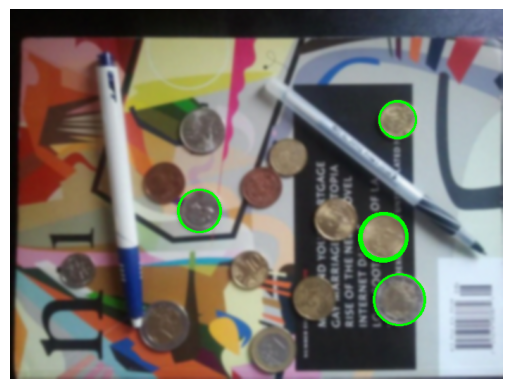

Testing with Gaussian noise sigma = 10.0
Detected 122 lines and 869 circles


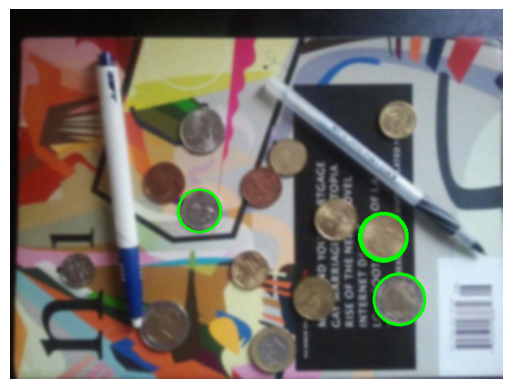

Testing with Gaussian noise sigma = 20.0
Detected 103 lines and 627 circles


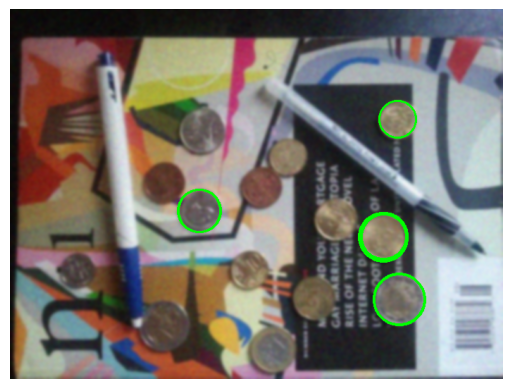

Testing with Gaussian noise sigma = 40.0
Detected 88 lines and 421 circles


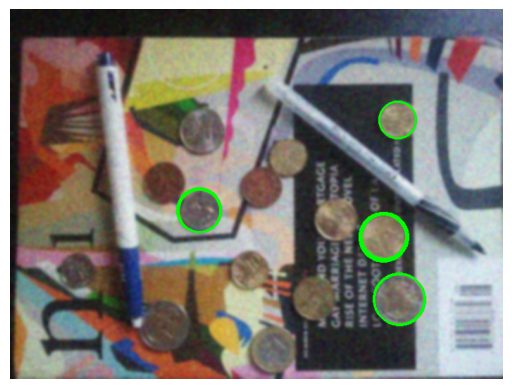

Testing with Gaussian noise sigma = 80.0
Detected 68 lines and 232 circles


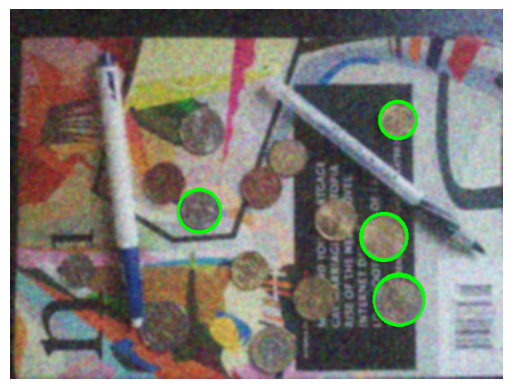

Testing with Gaussian noise sigma = 160.0
Detected 18 lines and 33 circles
Testing with Gaussian noise sigma = 320.0
Detected 6 lines and 0 circles
Detection failed at sigma = 320.0
Testing with failure sigma = 320.0


ValueError: too many values to unpack (expected 2)

In [61]:
def add_gaussian_noise(image, sigma):
    '''
    Adds Gaussian noise to an image.

    Input:
    - image: Original image
    - sigma: Standard deviation of the Gaussian noise

    Output:
    - noisy_image: Image with added Gaussian noise
    '''
    gauss = np.random.normal(0, sigma, image.shape).astype(np.float32)
    noisy_image = image.astype(np.float32) + gauss
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

def count_detected_lines(accumulator, acc_threshold):
    '''
    Counts the number of detected lines based on accumulator threshold.

    Input:
    - accumulator: Hough Transform accumulator array
    - acc_threshold: Threshold for accumulator votes

    Output:
    - num_lines: Number of lines detected
    '''
    indices = np.argwhere(accumulator > acc_threshold)
    num_lines = len(indices)
    return num_lines

def count_detected_circles(accumulator, acc_threshold):
    '''
    Counts the number of detected circles based on accumulator threshold.

    Input:
    - accumulator: Hough Transform accumulator array
    - acc_threshold: Threshold for accumulator votes

    Output:
    - num_circles: Number of circles detected
    '''
    indices = np.argwhere(accumulator > acc_threshold)
    num_circles = len(indices)
    return len(indices)

# Read the original clutter image
clutter_img = cv.imread('../data/proj2-clutter-image.jpg')

# Convert to grayscale 
clutter_gray = cv.cvtColor(clutter_img, cv.COLOR_BGR2GRAY)

# For Line Detection
line_sigma = 2  # Sigma for Gaussian smoothing
line_threshold = 90  # Threshold for binary image
line_theta_res = 2   # Theta resolution in degrees
line_rho_res = 1     # Rho resolution in pixels
line_acc_threshold = 180  # Accumulator threshold for line detection

# For Circle Detection
circle_sigma = 2  # Sigma for Gaussian smoothing
circle_threshold = 80        
circle_min_radius = 20       
circle_max_radius = 40       
circle_radius_res = 1        
circle_angle_res = 2        # degrees
circle_acc_threshold = 100   

# Starting sigma value for noise
noise_sigma_start = 5.0
# Initialize sigma value
noise_sigma = noise_sigma_start

# List to store sigma values where we will save images
sigma_values = []

# Variables to keep track of detection failure
failure_sigma = None
max_iterations = 10  # Maximum number of iterations

for i in range(max_iterations):
    print(f"Testing with Gaussian noise sigma = {noise_sigma}")

    # Add Gaussian noise to the image
    noisy_img = add_gaussian_noise(clutter_img, noise_sigma)
    cv.imwrite(f'../results/Ques_5/Noisy_Image_sigma_{int(noise_sigma)}.png', noisy_img)

    # Smooth the noisy image using the same parameters
    g_kernel_line = Gaussian_Filter(line_sigma)
    smooth_noisy_img_line = cv.filter2D(noisy_img, -1, g_kernel_line)
    cv.imwrite(f'../results/Ques_5/Smooth_Noisy_Image_Line_sigma_{int(noise_sigma)}.png', smooth_noisy_img_line)

    g_kernel_circle = Gaussian_Filter(circle_sigma)
    smooth_noisy_img_circle = cv.filter2D(noisy_img, -1, g_kernel_circle)
    cv.imwrite(f'../results/Ques_5/Smooth_Noisy_Image_Circle_sigma_{int(noise_sigma)}.png', smooth_noisy_img_circle)

    # Edge detection for line detection
    smooth_noisy_img_gray_line = detect_edges_with_sobel(smooth_noisy_img_line)
    # Edge detection for circle detection
    smooth_noisy_img_gray_circle = detect_edges_with_sobel(smooth_noisy_img_circle)

    
    # Hough Transform for lines
    # Edge detection for line detection
    smooth_noisy_img_gray_line   = detect_edges_with_sobel(smooth_noisy_img_line)
    # Edge detection for circle detection
    smooth_noisy_img_gray_circle = detect_edges_with_sobel(smooth_noisy_img_circle)

    # Convert edge outputs to 1‐channel GRAY if they’re still BGR
    if smooth_noisy_img_gray_line.ndim == 3:
        smooth_noisy_img_gray_line = cv.cvtColor(
            smooth_noisy_img_gray_line,
            cv.COLOR_BGR2GRAY
        )
    if smooth_noisy_img_gray_circle.ndim == 3:
        smooth_noisy_img_gray_circle = cv.cvtColor(
            smooth_noisy_img_gray_circle,
            cv.COLOR_BGR2GRAY
        )

    accumulator_line, thetas_line, rhos_line, binary_img_line = hough_transform(
        smooth_noisy_img_gray_line, line_threshold, line_theta_res, line_rho_res)
    num_lines = count_detected_lines(accumulator_line, line_acc_threshold)

    # Hough Transform for circles
    accumulator_circle, radius_vector_circle, center_x_vector_circle, center_y_vector_circle, binary_img_circle = circle_hough_transform(
        smooth_noisy_img_gray_circle, circle_threshold, circle_min_radius, circle_max_radius, circle_radius_res, circle_angle_res)
    num_circles = count_detected_circles(accumulator_circle, circle_acc_threshold)

    print(f"Detected {num_lines} lines and {num_circles} circles")

    # Save images at specific sigma values
    if len(sigma_values) < 5:
        sigma_values.append(noise_sigma)

        # Plot lines on the image
        plot_long_edges(f'../results/Ques_5/Smooth_Noisy_Image_Line_sigma_{int(noise_sigma)}.png', accumulator_line, thetas_line, rhos_line, line_acc_threshold, binary_img_line, length_threshold, f'../results/Ques_5/Noisy_Image_with_Lines_sigma_{int(noise_sigma)}.png')

        # Plot circles on the image
        plot_circles(f'../results/Ques_5/Smooth_Noisy_Image_Circle_sigma_{int(noise_sigma)}.png', accumulator_circle, radius_vector_circle, center_x_vector_circle, center_y_vector_circle, circle_acc_threshold, binary_img_circle, f'../results/Ques_5/Noisy_Image_with_Circles_sigma_{int(noise_sigma)}.png')

    # Determine failure
    if num_lines < 2 or num_circles < 2:
        failure_sigma = noise_sigma
        print(f"Detection failed at sigma = {failure_sigma}")
        break

    # Double the noise sigma for the next iteration
    noise_sigma *= 2

# If detection did not fail within max_iterations, set failure_sigma to the last value
if failure_sigma is None:
    failure_sigma = noise_sigma / 2
    print(f"Detection did not fail within maximum iterations. Setting failure_sigma = {failure_sigma}")

# Now, generate noisy image with failure_sigma and apply smoothing to recover detection
print(f"Testing with failure sigma = {failure_sigma}")

# Add Gaussian noise with failure sigma
noisy_img_failure = add_gaussian_noise(clutter_img, failure_sigma)
cv.imwrite(f'../results/Ques_5/Noisy_Image_failure_sigma_{int(failure_sigma)}.png', noisy_img_failure)

# Determine smoothing filter to handle maximum noise
# Increase sigma for Gaussian filter
failure_line_sigma = line_sigma * 2  
failure_circle_sigma = circle_sigma * 2

# Apply smoothing
g_kernel_failure_line = Gaussian_Filter(failure_line_sigma)
smooth_noisy_img_failure_line = cv.filter2D(noisy_img_failure, -1, g_kernel_failure_line)
cv.imwrite(f'../results/Ques_5/Smooth_Noisy_Image_failure_Line.png', smooth_noisy_img_failure_line)

g_kernel_failure_circle = Gaussian_Filter(failure_circle_sigma)
smooth_noisy_img_failure_circle = cv.filter2D(noisy_img_failure, -1, g_kernel_failure_circle)
cv.imwrite(f'../results/Ques_5/Smooth_Noisy_Image_failure_Circle.png', smooth_noisy_img_failure_circle)

# Edge detection
smooth_noisy_img_failure_gray_line = detect_edges_with_sobel(smooth_noisy_img_failure_line)
smooth_noisy_img_failure_gray_circle = detect_edges_with_sobel(smooth_noisy_img_failure_circle)

# Hough Transform for lines
accumulator_failure_line, thetas_failure_line, rhos_failure_line, binary_img_failure_line = hough_transform(
    smooth_noisy_img_failure_gray_line, line_threshold, line_theta_res, line_rho_res)
num_lines_failure = count_detected_lines(accumulator_failure_line, line_acc_threshold)
print(f"After smoothing, detected {num_lines_failure} lines")

# Hough Transform for circles
accumulator_failure_circle, radius_vector_failure_circle, center_x_vector_failure_circle, center_y_vector_failure_circle, binary_img_failure_circle = circle_hough_transform(
    smooth_noisy_img_failure_gray_circle, circle_threshold, circle_min_radius, circle_max_radius, circle_radius_res, circle_angle_res)
num_circles_failure = count_detected_circles(accumulator_failure_circle, circle_acc_threshold)
print(f"After smoothing, detected {num_circles_failure} circles")

# Plot lines and circles on the smoothed images
plot_long_edges(f'../results/Ques_5/Smooth_Noisy_Image_failure_Line.png', accumulator_failure_line, thetas_failure_line, rhos_failure_line, line_acc_threshold, binary_img_failure_line, length_threshold, '../results/Ques_5/Noisy_Image_with_Lines_failure_sigma.png')

plot_circles(f'../results/Ques_5/Smooth_Noisy_Image_failure_Circle.png', accumulator_failure_circle, radius_vector_failure_circle, center_x_vector_failure_circle, center_y_vector_failure_circle, circle_acc_threshold, binary_img_failure_circle, '../results/Ques_5/Noisy_Image_with_Circles_failure_sigma.png')